## Примеры кода на pyspark

В качестве набора данных для примера будем использовать данные конкурса про ответы студентов на тесты  
https://www.kaggle.com/c/riiid-test-answer-prediction

In [1]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import findspark
findspark.init()

Нужно выбрать уникальное имя приложения и номер порта, чтобы не войти в коллизию с другими пользователями

In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("OTUS-Solution")
        .getOrCreate()
)

Данные будем читать из заранее сконвертированного parquet

In [4]:
df = spark.read.parquet("data/train.parquet",)

Схема данных и первые 10 записей

In [5]:
df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- content_id: integer (nullable = true)
 |-- content_type_id: integer (nullable = true)
 |-- task_container_id: integer (nullable = true)
 |-- user_answer: integer (nullable = true)
 |-- answered_correctly: integer (nullable = true)
 |-- prior_question_elapsed_time: double (nullable = true)
 |-- prior_question_had_explanation: boolean (nullable = true)



In [6]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)  # to pretty print pyspark.DataFrame in jupyter
df.limit(10)

row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62896,96541616,1400354,1087,0,94,3,0,17000.0,false
104413,21162902,2211492,5262,0,95,0,1,11000.0,true
537225,4538020,10854346,7880,0,26,1,1,30000.0,true
158202,95544,3237407,1278,0,3,0,0,23000.0,false
75576,45311590335,1567938,768,0,1665,0,1,17000.0,true
66732,17442041210,1440282,8340,0,3064,2,0,15000.0,true
256332,1868941165,4742725,8750,0,4144,0,0,14000.0,true
539919,3904128913,10938316,5986,0,596,0,1,12000.0,true
61801,8203657701,1308136,1289,0,20,3,1,19000.0,true
524048,2489081997,10353031,5262,0,195,0,1,24000.0,true


Замерим время выполнения простых запросов с группировками

In [7]:
from pyspark.sql import functions as f
from pyspark.sql.functions import col

In [8]:
%%time
(
df
    .select('content_id', 'answered_correctly')
    .groupby('content_id')
    .mean('answered_correctly')
    .toPandas()
)

CPU times: user 65 ms, sys: 7.62 ms, total: 72.6 ms
Wall time: 3.92 s


,content_id,avg(answered_correctly)
0,7880,0.929134
1,1342,0.661290
2,7993,0.545455
3,6466,0.536585
4,5300,0.539474
...,...,...
13315,6153,0.625000
13316,3406,1.000000
13317,7466,1.000000
13318,12444,1.000000


In [9]:
%%time
(
df
    .select('user_id', 'answered_correctly')
    .groupby('user_id')
    .mean('answered_correctly')
    .toPandas()
)

CPU times: user 78.4 ms, sys: 4.8 ms, total: 83.2 ms
Wall time: 5.82 s


,user_id,avg(answered_correctly)
0,9656713,0.802817
1,3233182,0.627662
2,9970282,0.741430
3,6431206,0.617089
4,7039142,0.576923
...,...,...
3819,12092959,0.460000
3820,19997619,0.294118
3821,14531615,0.705882
3822,20443589,0.533333


## Упражнение 1
Выведите top 10 студентов с наилучшими результатами

In [10]:
%%time
(
df
    .select("user_id", "answered_correctly")
    .groupBy("user_id")
    .mean("answered_correctly")
    .orderBy("avg(answered_correctly)", ascending=False)
    .limit(10)
    .toPandas()
)

CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 2.1 s


,user_id,avg(answered_correctly)
0,1880240,1.000000
1,7528236,0.967742
2,19087497,0.967742
3,3126556,0.966667
4,7788970,0.966667
5,19190311,0.937500
6,10905154,0.933333
7,2212092,0.928571
8,1534292,0.923077
9,14998785,0.917647


## Упражнение 2
Выведите top 10 задач с наихудшими результатами

In [11]:
%%time
(
df
    .select("content_id", "answered_correctly")
    .filter(col("answered_correctly") >= 0)
    .groupBy("content_id")
    .mean("answered_correctly")
    .orderBy("avg(answered_correctly)", ascending=True)
    .limit(10)
    .toPandas()
)

CPU times: user 12.4 ms, sys: 2.96 ms, total: 15.4 ms
Wall time: 2.16 s


,content_id,avg(answered_correctly)
0,12530,0.0
1,13172,0.0
2,4401,0.0
3,12344,0.0
4,9338,0.0
5,516,0.0
6,12799,0.0
7,1884,0.0
8,13060,0.0
9,3042,0.0


## pyspark user defined functions (UDF)

Как и для других языков, поддерживаемых Spark, для python есть возможность использовать UDF. При этом возникают дополнительные накладные расходы по сравнению с Java и Scala.

In [12]:
from pyspark.sql.types import LongType

def to_months(ms):
    return ms // 31536000000 // 12 #1 year = 31536000000 ms

to_months_udf = f.udf(to_months, LongType())

Замерим время выполнения без UDF

In [13]:
%%time
(
    df
        .select("content_id", "timestamp")
        .groupby("content_id")
        .mean("timestamp")
        .toPandas()
)

CPU times: user 57.6 ms, sys: 8.24 ms, total: 65.9 ms
Wall time: 1.49 s


,content_id,avg(timestamp)
0,12027,1.161331e+10
1,3749,7.853523e+09
2,1238,7.750564e+09
3,4101,7.798759e+09
4,2866,1.072848e+10
...,...,...
13315,12444,1.369568e+09
13316,11292,9.351786e+09
13317,12916,6.376033e+10
13318,7476,1.320012e+09


Применим простой UDF к похожему запросу

In [14]:
%%time
(
    df
        .select("content_id", to_months_udf("timestamp").alias("months"))
        .groupBy("content_id")
        .mean("months")
        .toPandas()
)

CPU times: user 55.7 ms, sys: 10.5 ms, total: 66.2 ms
Wall time: 5.05 s


,content_id,avg(months)
0,12027,0.0
1,3749,0.0
2,1238,0.0
3,4101,0.0
4,2866,0.0
...,...,...
13315,12622,0.0
13316,6153,0.0
13317,3406,0.0
13318,7466,0.0


Перепишем логику, которая была в UDF

In [15]:
%%time
(
    df
        .select("content_id", (col("timestamp") / 31536000000 / 12).alias("months"))
        .groupby("content_id")
        .mean("months")
        .toPandas()
)

CPU times: user 53.6 ms, sys: 11.2 ms, total: 64.8 ms
Wall time: 1.48 s


,content_id,avg(months)
0,12027,0.030688
1,3749,0.020753
2,1238,0.020481
3,4101,0.020608
4,2866,0.028350
...,...,...
13315,12622,0.087396
13316,6153,0.004183
13317,3406,0.000634
13318,7466,0.038415


## Упражнение 3
Постройте гистограмму по числу месяцев до первого взаимодействия студента с заданием

In [ ]:
# Используем pandas
months_data = df.select(col('timestamp') / 31536000000 / 12).toPandas().values.flatten()
frequencies, bins = np.histogram(months_data, bins=100)
days_histogram = (bins, frequencies)

In [27]:
days_histogram

(array([0.        , 0.00206357, 0.00412713, 0.0061907 , 0.00825427,
        0.01031784, 0.0123814 , 0.01444497, 0.01650854, 0.01857211,
        0.02063567, 0.02269924, 0.02476281, 0.02682638, 0.02888994,
        0.03095351, 0.03301708, 0.03508065, 0.03714421, 0.03920778,
        0.04127135, 0.04333492, 0.04539848, 0.04746205, 0.04952562,
        0.05158919, 0.05365275, 0.05571632, 0.05777989, 0.05984346,
        0.06190702, 0.06397059, 0.06603416, 0.06809773, 0.07016129,
        0.07222486, 0.07428843, 0.076352  , 0.07841556, 0.08047913,
        0.0825427 , 0.08460627, 0.08666983, 0.0887334 , 0.09079697,
        0.09286054, 0.0949241 , 0.09698767, 0.09905124, 0.10111481,
        0.10317837, 0.10524194, 0.10730551, 0.10936908, 0.11143264,
        0.11349621, 0.11555978, 0.11762335, 0.11968691, 0.12175048,
        0.12381405, 0.12587762, 0.12794118, 0.13000475, 0.13206832,
        0.13413189, 0.13619545, 0.13825902, 0.14032259, 0.14238616,
        0.14444972, 0.14651329, 0.14857686, 0.15

In [28]:
import numpy as np

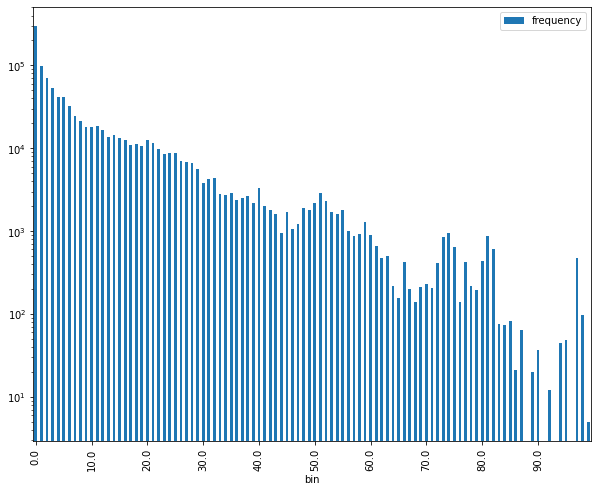

In [29]:
ax = pd.DataFrame(
    list(zip(*days_histogram)), columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar', figsize=(10,8))
ax.set_yscale('log')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, tick_num: np.round(x, 2)))

## Упражнение 4
В файле "lectures.csv" хранится информация об лекциях. Объедините эту таблицу с основным набором данных при условии, что content_type_id == 1.

In [31]:
!hadoop distcp s3a://otus-bucket-b1gcq77orp7o97v8lnkm/lectures.csv /user/ubuntu/data/lectures.csv

2025-12-03 01:24:36,985 INFO tools.DistCp: Input Options: DistCpOptions{atomicCommit=false, syncFolder=false, deleteMissing=false, ignoreFailures=false, overwrite=false, append=false, useDiff=false, useRdiff=false, fromSnapshot=null, toSnapshot=null, skipCRC=false, blocking=true, numListstatusThreads=0, maxMaps=20, mapBandwidth=0.0, copyStrategy='uniformsize', preserveStatus=[], atomicWorkPath=null, logPath=null, sourceFileListing=null, sourcePaths=[s3a://otus-bucket-b1gcq77orp7o97v8lnkm/lectures.csv], targetPath=/user/ubuntu/data/lectures.csv, filtersFile='null', blocksPerChunk=0, copyBufferSize=8192, verboseLog=false, directWrite=false}, sourcePaths=[s3a://otus-bucket-b1gcq77orp7o97v8lnkm/lectures.csv], targetPathExists=false, preserveRawXattrsfalse
2025-12-03 01:24:37,055 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2025-12-03 01:24:37,055 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2025-12-03 01:24:37,171 INFO impl.Metric

In [32]:
lectures = spark.read.csv("data/lectures.csv", header=True, inferSchema=True)

In [33]:
lec_df = (
    df
        .where(f.col("content_type_id") == 1)
        .join(lectures, df.content_id == lectures.lecture_id, 'left')
)

In [34]:
%%time
(
lec_df
    .groupBy("tag")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
    .toPandas()
)

CPU times: user 14.2 ms, sys: 0 ns, total: 14.2 ms
Wall time: 1.7 s


,tag,count
0,62,601
1,27,553
2,136,420
3,163,400
4,26,393
5,161,392
6,170,376
7,1,351
8,73,337
9,53,321
